##**SUPERVISED LEARNING**

---

##0.REFERENCE

https://claude.ai/share/72096a20-7044-4966-b456-e4c52e5f7444

##1.CONTEXT



Most trading strategies fail not because the idea is bad, but because the implementation is flawed. Look-ahead bias—using information you wouldn't have known at decision time—is the silent killer of quantitative trading. A backtest shows 30% annual returns, but live trading loses money from day one. This notebook teaches you to build forecasting models that survive contact with reality.

We're building **predictive models that forecast future returns**. Given today's market data, will the stock go up or down tomorrow? How confident should we be? These aren't academic exercises—this is the foundation of systematic trading at hedge funds and prop shops worldwide. The difference between profitable and unprofitable quant trading often comes down to rigorous implementation discipline, not clever algorithms.

**What Makes This Different**

**No pandas, no shortcuts**. We use only NumPy and Python's standard library. Why? Because when you build rolling windows, time-series joins, and cross-sectional rankings from scratch, you understand exactly what's happening. When your live strategy behaves differently than your backtest, you'll know where to look. Hidden in pandas' convenience functions are dozens of subtle choices about how missing data propagates, how time alignment works, and what "shift" really means.

**Governance-native from day one**. Every calculation gets hashed. Every data transformation gets logged. Every model prediction gets timestamped. This isn't overhead—it's your insurance policy. When regulators ask "how did you generate this return forecast on March 15th?", you need to prove it. When your CIO asks "why did the model suddenly stop working?", you need to trace it back to data quality, not guess.

**Synthetic data first, real data optional**. We generate artificial price series with realistic properties: volatility clustering, regime changes, and microstructure noise. This lets you experiment freely, understand edge cases, and verify your causality checks work. The real-data adapter is isolated—turn it on only when your synthetic tests pass.
**What You'll Learn**

You'll implement **causal feature engineering**: lagged returns, realized volatility, moving average deviations, z-scores, and volume surprises—all computed using only past information. Then you'll build **three baseline models**: ordinary least squares regression, logistic regression for direction, and decision stumps. No deep learning complexity here—we're establishing foundations.

**Walk-forward validation** replaces train-test splits. You'll learn expanding and rolling window schemes, proper purging of overlapping labels, and embargo periods that prevent leakage. The evaluation metrics go beyond accuracy: information coefficient, directional accuracy, and Sharpe ratio tell you if your forecasts actually contain trading alpha.

Finally, you'll see the **handshake between forecasts and positions**. A model that predicts "+0.02% return" doesn't tell you how much to trade. You'll implement threshold rules, risk targeting from Chapter 10, and cost-aware position sizing. The equity curve you see accounts for transaction costs—not the fantasy version.

**Who This Is For**

Whether you're an MBA student exploring quantitative finance, a developer building trading infrastructure, or a portfolio manager finally understanding what your quants do, this notebook gives you the foundations. The code runs in minutes, requires no special hardware, and produces audit-quality documentation that institutional investors actually respect.

This is how professionals build trading models. No magic, no hand-waving—just rigorous engineering discipline applied to financial forecasting.

##2.LIBRARIES AND ENVIRONMENT

###2.1.OVERVIEW



This notebook teaches you how to build **machine learning models that predict stock returns** using only NumPy—no pandas, no shortcuts. Why? Because understanding the mechanics from scratch makes you a better quant. You'll learn to forecast whether a stock will go up or down tomorrow, then convert those predictions into actual trading positions.

We enforce **strict causality**: your model at time *t* can only use information available *before* time *t*. This prevents "look-ahead bias"—the silent killer that makes backtests look profitable but fails in live trading. Every calculation is **deterministic** (same random seed = same results) and **auditable** (cryptographic hashes verify nothing changed).

The governance framework isn't bureaucracy—it's survival. When your strategy loses money, you need to know: Was it bad luck or a coding bug? Our manifests, lineage logs, and artifact hashes let you trace every number back to its source.

**Configuration and Setup**

All parameters live in one place: the `CONFIG` dictionary. Random seeds ensure reproducibility. We generate **synthetic market data** with three regimes (calm, stress, recovery) that mimic real volatility clustering. Synthetic-first means you can experiment freely before risking real capital.

We create an artifact directory structure where every output gets saved: data fingerprints, feature definitions, model predictions, performance metrics, and plots. The run ID combines timestamp and config hash—if you change *anything*, you get a new run ID. This makes it impossible to accidentally overwrite results or lose track of what configuration produced which outcome.

Think of this as building a "black box" for your trading models—everything is recorded, timestamped, and tamper-evident.


###2.2.CODE AND IMPLEMENTATION

In [ ]:
import os
import json
import math
import time
import hashlib
import datetime
import warnings
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', message='.*utcnow.*')

# Configure numpy to handle errors silently where appropriate
np.seterr(invalid='ignore', divide='ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Set professional plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 100

# ==========================================================
# Cell 1 — Imports, Utilities, Governance Primitives
# ==========================================================

def sha256_bytes(b: bytes) -> str:
    """Compute SHA256 hash of bytes."""
    return hashlib.sha256(b).hexdigest()

def sha256_str(s: str) -> str:
    """Compute SHA256 hash of string."""
    return sha256_bytes(s.encode("utf-8"))

def sha256_ndarray(x: np.ndarray) -> str:
    """Stable hash across runs given same dtype/shape/content."""
    return sha256_bytes(x.tobytes() + str(x.shape).encode("utf-8") + str(x.dtype).encode("utf-8"))

def now_utc_compact() -> str:
    """Return current UTC time in compact format."""
    return datetime.datetime.now(datetime.timezone.utc).strftime("%Y%m%dT%H%M%SZ")

def ensure_dir(p: str) -> None:
    """Create directory if it doesn't exist."""
    os.makedirs(p, exist_ok=True)

def save_json(path: str, obj: Dict) -> None:
    """Save dictionary as JSON file."""
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, sort_keys=True)

def save_txt(path: str, s: str) -> None:
    """Save string as text file."""
    with open(path, "w", encoding="utf-8") as f:
        f.write(s)

def np_save(path: str, arr: np.ndarray) -> None:
    """Save numpy array."""
    np.save(path, arr)

def assert_monotone_time(t: np.ndarray) -> None:
    """Assert that time index is strictly increasing."""
    assert t.ndim == 1, "Time index must be 1-dimensional"
    dt = np.diff(t)
    assert np.all(dt > 0), "Time index must be strictly increasing"

def annualize_sharpe(r: np.ndarray, periods_per_year: int = 252) -> float:
    """Calculate annualized Sharpe ratio."""
    r = r.astype(float)
    mu = np.mean(r)
    sd = np.std(r, ddof=0)
    if sd <= 0:
        return 0.0
    return (mu / sd) * math.sqrt(periods_per_year)

def max_drawdown(equity_curve: np.ndarray) -> float:
    """Calculate maximum drawdown from equity curve."""
    peak = -np.inf
    mdd = 0.0
    for v in equity_curve:
        if v > peak:
            peak = v
        dd = (peak - v) / peak if peak > 0 else 0.0
        if dd > mdd:
            mdd = dd
    return float(mdd)

def safe_metric(func, *args, default=0.0, **kwargs):
    """Safely compute metric with NaN handling."""
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            result = func(*args, **kwargs)
            if not np.isfinite(result):
                return default
            return result
    except Exception:
        return default

def corr_ic(a: np.ndarray, b: np.ndarray) -> float:
    """Calculate correlation coefficient (information coefficient) with NaN handling."""
    a = a.astype(float)
    b = b.astype(float)

    # Remove NaN values
    mask = np.isfinite(a) & np.isfinite(b)
    a_clean = a[mask]
    b_clean = b[mask]

    if a_clean.size < 2:
        return 0.0

    sa = np.std(a_clean)
    sb = np.std(b_clean)

    if sa <= 0 or sb <= 0:
        return 0.0

    return float(np.corrcoef(a_clean, b_clean)[0, 1])

def directional_accuracy_from_regression(pred: np.ndarray, y: np.ndarray) -> float:
    """Calculate directional accuracy from regression predictions with NaN handling."""
    pred = pred.astype(float)
    y = y.astype(float)

    # Remove NaN values
    mask = np.isfinite(pred) & np.isfinite(y)
    pred_clean = pred[mask]
    y_clean = y[mask]

    if pred_clean.size == 0:
        return 0.0

    sp = np.sign(pred_clean)
    sy = np.sign(y_clean)
    ok = (sp == sy)
    return float(np.mean(ok))

def log_loss_binary(p: np.ndarray, y01: np.ndarray, eps: float = 1e-12) -> float:
    """Calculate binary log loss with NaN handling."""
    p = p.astype(float)
    y01 = y01.astype(float)

    # Remove NaN values
    mask = np.isfinite(p) & np.isfinite(y01)
    p_clean = p[mask]
    y01_clean = y01[mask]

    if p_clean.size == 0:
        return np.nan

    p_clean = np.clip(p_clean, eps, 1 - eps)
    return float(-np.mean(y01_clean * np.log(p_clean) + (1 - y01_clean) * np.log(1 - p_clean)))

def sigmoid(z: np.ndarray) -> np.ndarray:
    """Numerically stable sigmoid function with NaN handling."""
    z = z.astype(float)

    # Handle NaN inputs
    mask_nan = ~np.isfinite(z)
    z_clean = z.copy()
    z_clean[mask_nan] = 0.0  # Temporary replacement

    out = np.empty_like(z_clean)
    pos = z_clean >= 0
    neg = ~pos

    # Compute sigmoid
    out[pos] = 1.0 / (1.0 + np.exp(-z_clean[pos]))
    ez = np.exp(z_clean[neg])
    out[neg] = ez / (1.0 + ez)

    # Restore NaN where input was NaN
    out[mask_nan] = np.nan

    return out



CONFIG = {
    # Determinism
    "seeds": {
        "seed_data": 12345,
        "seed_model": 23456,
        "seed_eval": 34567,
    },

    # Synthetic market generator
    "synthetic": {
        "T": 2200,
        "regime_schedule": [0, 700, 1400, 2200],
        "regimes": [
            {"mu": 0.0002, "sigma": 0.010, "phi_vol": 0.92},  # calm
            {"mu": -0.0001, "sigma": 0.018, "phi_vol": 0.95},  # stress
            {"mu": 0.00015, "sigma": 0.012, "phi_vol": 0.90},  # recovery
        ],
        "micro_noise_sigma": 0.0008,
        "volume_base": 1.0e6,
        "volume_vol_sensitivity": 30.0,
    },

    # Labels
    "label": {
        "horizon_h": 1,
        "return_type": "log",
        "direction_threshold": 0.0,
    },

    # Features
    "features": {
        "max_lookback": 60,
        "r_lags": [1, 2, 5, 10, 20],
        "rv_windows": [5, 20],
        "ma_windows": [10, 50],
        "z_window": 20,
        "vol_surp_window": 20,
        "eps": 1e-8,
        "scaling": {
            "method": "expanding",
        }
    },

    # Walk-forward evaluation
    "walkforward": {
        "scheme": "expanding",
        "train_min": 600,
        "train_len": 800,
        "test_len": 100,
        "embargo": 0,
        "purge_h": True,
    },

    # Models
    "models": {
        "ols": True,
        "logistic": True,
        "tree_stump": True,
        "logistic_gd": {
            "lr": 0.15,
            "iters": 250,
            "l2": 0.0,
        }
    },

    # Signal -> position mapping
    "trading_map": {
        "forecast_threshold_tau": 0.0,
        "use_quantile_threshold": False,
        "quantile_alpha": 0.10,
        "risk_targeting": {
            "enabled": True,
            "target_vol_annual": 0.12,
            "vol_window": 20,
            "vol_floor": 0.002,
            "position_cap": 2.0,
        },
        "costs": {
            "enabled": True,
            "cost_per_unit_turnover": 0.0002,
        }
    },

    # Output
    "output": {
        "artifacts_root": "/content/artifacts_ch11",
        "plots": True,
    }
}

# Set global numpy seed
np.random.seed(CONFIG["seeds"]["seed_eval"])

# Create run ID and artifact directories
config_hash = sha256_str(json.dumps(CONFIG, sort_keys=True))
run_id = f"ch11_{now_utc_compact()}_{config_hash[:10]}"
ART_ROOT = os.path.join(CONFIG["output"]["artifacts_root"], run_id)

# Create directory structure
for subdir in ["data", "features", "labels", "splits", "models", "eval", "plots", "manifests"]:
    ensure_dir(os.path.join(ART_ROOT, subdir))

# Save config
save_json(os.path.join(ART_ROOT, "manifests", "config.json"), CONFIG)


##3.GENERATING SYNTHETIC DATA

###3.1.OVERVIEW



This section creates artificial price data that behaves like real markets—without needing actual market data. Why synthetic? Because you can control everything: test edge cases, verify your code handles regime changes, and ensure causality checks work before risking capital on real data bugs.

**The generator produces realistic market dynamics**. We simulate three market regimes (calm, stress, recovery) with different volatility and drift parameters. Volatility doesn't jump randomly—it clusters through an autoregressive process, just like real markets where high-volatility days follow high-volatility days. This tests whether your features can adapt to changing market conditions.

**We create a complete price history**: closing prices built from log returns, plus Open-High-Low-Close (OHLC) bars for range-based features, and volume that correlates with volatility (more trading during volatile periods). The microstructure noise parameter adds small random jitters that mimic bid-ask bounce and quote flickering.

**Every piece of generated data gets fingerprinted**. We compute SHA256 hashes of the price series, returns, volume, and regime labels. These hashes go into a data manifest file with metadata: number of periods, regime boundaries, missingness statistics, and generator parameters. Six months from now, when someone asks "what data did you use?", you can prove exactly which synthetic series fed your model.

The visualization shows price and volatility over time with color-coded regime backgrounds. Calm periods have low volatility, stress periods show spikes, recovery periods stabilize. If your model can't handle these controlled regime shifts in synthetic data, it definitely won't handle real market crises.

###3.2.CODE AND IMPLEMENTATION

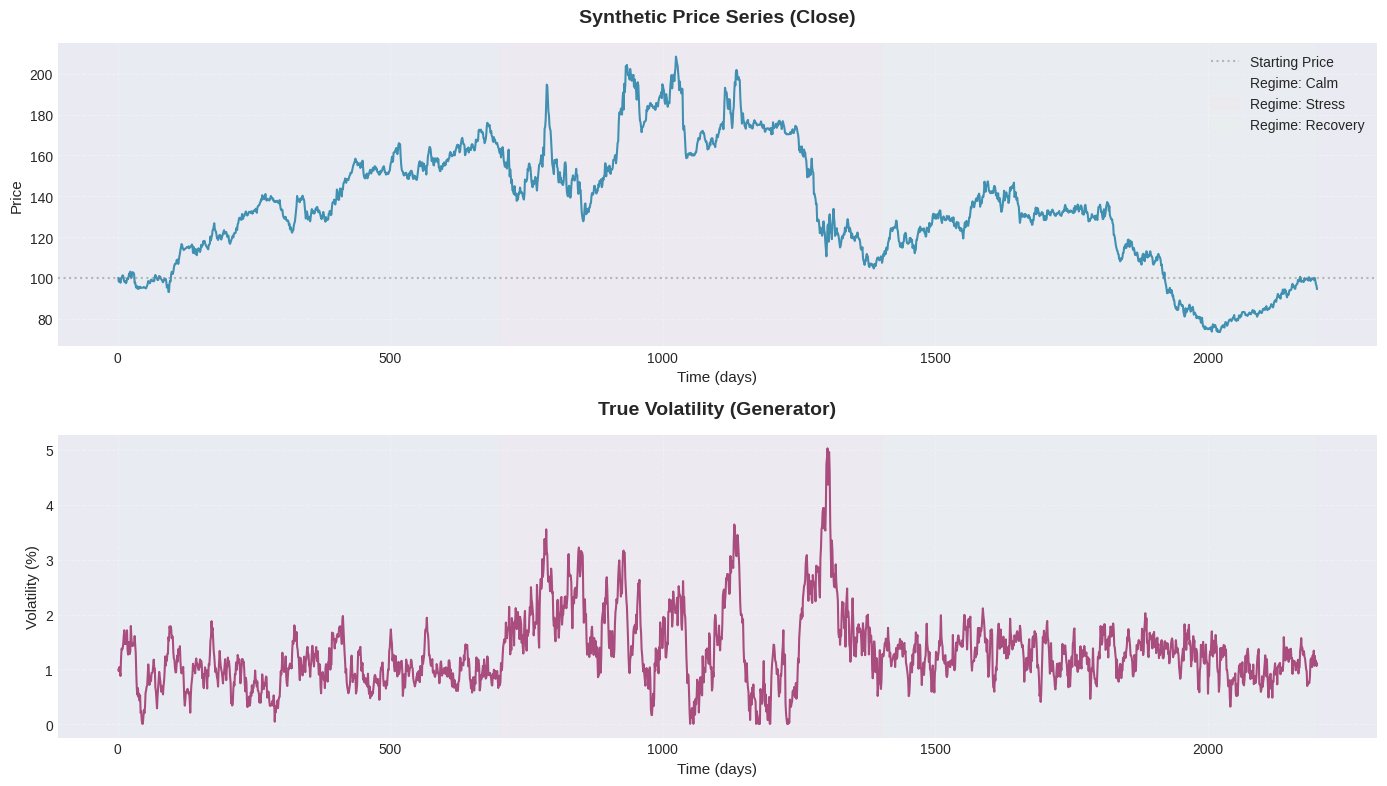

In [7]:

def generate_synthetic_market(cfg: Dict) -> Dict[str, np.ndarray]:
    """Generate synthetic market data with regime changes and volatility clustering."""
    np.random.seed(cfg["seeds"]["seed_data"])

    T = cfg["synthetic"]["T"]
    sched = cfg["synthetic"]["regime_schedule"]
    regs = cfg["synthetic"]["regimes"]
    micro_sigma = cfg["synthetic"]["micro_noise_sigma"]

    # Time index (integer days)
    t = np.arange(T, dtype=np.int64) + 1
    assert_monotone_time(t)

    # Regime ID per time
    reg_id = np.zeros(T, dtype=np.int64)
    for k in range(len(regs)):
        a, b = sched[k], sched[k + 1]
        reg_id[a:b] = k

    # Stochastic volatility process
    sigma_t = np.zeros(T, dtype=float)
    r = np.zeros(T, dtype=float)

    sigma_t[0] = regs[int(reg_id[0])]["sigma"]
    for i in range(1, T):
        rid = int(reg_id[i])
        base_sigma = regs[rid]["sigma"]
        phi = regs[rid]["phi_vol"]
        sigma_t[i] = phi * sigma_t[i - 1] + (1 - phi) * base_sigma + 0.15 * base_sigma * np.random.randn()
        sigma_t[i] = max(sigma_t[i], 1e-4)

    # Returns: mu + sigma * eps + micro noise
    for i in range(1, T):
        rid = int(reg_id[i])
        mu = regs[rid]["mu"]
        r[i] = mu + sigma_t[i] * np.random.randn() + micro_sigma * np.random.randn()

    # Build price from log returns
    logP = np.zeros(T, dtype=float)
    logP[0] = math.log(100.0)
    logP[1:] = logP[0] + np.cumsum(r[1:])
    P = np.exp(logP)

    # Simple OHLC proxy
    rng = np.abs(np.random.randn(T)) * sigma_t * P
    H = P + 0.5 * rng
    L = np.maximum(P - 0.5 * rng, 1e-6)
    O = np.empty_like(P)
    O[0] = P[0]
    O[1:] = P[:-1] * np.exp(0.25 * r[1:] + 0.1 * sigma_t[1:] * np.random.randn(T - 1))

    # Volume correlated with volatility
    vbase = cfg["synthetic"]["volume_base"]
    v_sens = cfg["synthetic"]["volume_vol_sensitivity"]
    V = vbase * (1.0 + v_sens * sigma_t) * np.exp(0.15 * np.random.randn(T))
    V = np.maximum(V, 1.0)

    return {
        "t": t,
        "regime": reg_id,
        "P": P,
        "logP": logP,
        "O": O,
        "H": H,
        "L": L,
        "V": V,
        "r_log": r,
        "sigma_true": sigma_t,
    }

# Generate data
data = generate_synthetic_market(CONFIG)

# Create data fingerprint
data_fingerprint = {
    "type": "synthetic",
    "run_id": run_id,
    "instruments": ["SYNTH_1"],
    "frequency": "daily",
    "span": [int(data["t"][0]), int(data["t"][-1])],
    "missingness": {k: float(np.mean(~np.isfinite(v))) for k, v in data.items() if isinstance(v, np.ndarray)},
    "corporate_action_policy": "synthetic_n/a",
    "generator": {
        "regime_schedule": CONFIG["synthetic"]["regime_schedule"],
        "regimes": CONFIG["synthetic"]["regimes"],
        "micro_noise_sigma": CONFIG["synthetic"]["micro_noise_sigma"],
    },
    "hashes": {
        "P": sha256_ndarray(data["P"]),
        "r_log": sha256_ndarray(data["r_log"]),
        "V": sha256_ndarray(data["V"]),
        "regime": sha256_ndarray(data["regime"]),
    }
}
save_json(os.path.join(ART_ROOT, "manifests", "data_fingerprint.json"), data_fingerprint)

# Save core arrays
np_save(os.path.join(ART_ROOT, "data", "P.npy"), data["P"])
np_save(os.path.join(ART_ROOT, "data", "r_log.npy"), data["r_log"])
np_save(os.path.join(ART_ROOT, "data", "V.npy"), data["V"])
np_save(os.path.join(ART_ROOT, "data", "regime.npy"), data["regime"])

# Visualize
if CONFIG["output"]["plots"]:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

    # Price plot
    ax1.plot(data["t"], data["P"], linewidth=1.5, color='#2E86AB', alpha=0.9)
    ax1.set_title("Synthetic Price Series (Close)", fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel("Time (days)", fontsize=11)
    ax1.set_ylabel("Price", fontsize=11)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.axhline(y=100, color='gray', linestyle=':', alpha=0.5, label='Starting Price')

    # Add regime backgrounds
    regime_colors = ['#E8F4F8', '#FFE5E5', '#E8F8E8']
    regime_labels = ['Calm', 'Stress', 'Recovery']
    for i, (start, end) in enumerate(zip(CONFIG["synthetic"]["regime_schedule"][:-1],
                                          CONFIG["synthetic"]["regime_schedule"][1:])):
        ax1.axvspan(start, end, alpha=0.15, color=regime_colors[i], label=f'Regime: {regime_labels[i]}')
    ax1.legend(loc='best', framealpha=0.9)

    # Volatility plot
    ax2.plot(data["t"], data["sigma_true"] * 100, linewidth=1.5, color='#A23B72', alpha=0.9)
    ax2.set_title("True Volatility (Generator)", fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel("Time (days)", fontsize=11)
    ax2.set_ylabel("Volatility (%)", fontsize=11)
    ax2.grid(True, alpha=0.3, linestyle='--')

    # Add regime backgrounds
    for i, (start, end) in enumerate(zip(CONFIG["synthetic"]["regime_schedule"][:-1],
                                          CONFIG["synthetic"]["regime_schedule"][1:])):
        ax2.axvspan(start, end, alpha=0.15, color=regime_colors[i])

    plt.tight_layout()
    plt.savefig(os.path.join(ART_ROOT, "plots", "data_overview.png"), dpi=150, bbox_inches='tight')
    plt.show()


##4.LABELS AND LABEL MANIFEST

###4.1.OVERVIEW



This section defines **what we're trying to predict**: future returns. The label is the ground truth your model learns from. Getting this wrong means your entire strategy is fundamentally broken, so we're obsessively careful about timing.

**The decision-time convention is explicit**: At time *t*, you observe all data up to and including time *t*. Your features X_t will use information through time *t* (or actually *t-1* after our safety shift). The label y_t represents the forward return starting at *t+1*. For a 1-day horizon, y_t = r_{t+1}. This ensures X_t predicts y_t without seeing the future—causality preserved.

**We create two label types**. The continuous label (y) is the actual forward return—suitable for regression models like OLS that output real-valued forecasts. The binary direction label (y_dir) is 1 if the return exceeds threshold (default 0), else 0—suitable for classification models like logistic regression that predict up/down.

**The label manifest documents everything**: horizon length, return type (log vs simple), the mathematical definition, direction threshold, and cryptographic hashes of both label arrays. This isn't paranoia—when your model stops working, you'll need to verify the labels didn't change due to data vendor updates or preprocessing bugs.

The last *h* rows of the label array are NaN—we can't predict the future beyond our data. This creates a natural boundary that prevents accidentally training on data you won't have when trading live. The causality gate explicitly checks this: if those final labels aren't NaN, execution halts immediately.

###4.2.CODE AND IMPLEMENTATION

In [9]:



def compute_returns(P: np.ndarray, return_type: str = "log") -> np.ndarray:
    """Compute returns from price series."""
    r = np.zeros_like(P, dtype=float)
    if return_type == "log":
        r[1:] = np.log(P[1:] / P[:-1])
    elif return_type == "simple":
        r[1:] = (P[1:] / P[:-1]) - 1.0
    else:
        raise ValueError("return_type must be 'log' or 'simple'")
    return r

def make_forward_return_label(r: np.ndarray, h: int) -> np.ndarray:
    """Create forward return label: y_t = sum_{j=1..h} r_{t+j}."""
    y = np.full_like(r, np.nan, dtype=float)
    T = r.size
    for t in range(T):
        j2 = t + h
        if j2 < T:
            y[t] = np.sum(r[t + 1:j2 + 1])
    return y

r = compute_returns(data["P"], CONFIG["label"]["return_type"])
h = int(CONFIG["label"]["horizon_h"])
y = make_forward_return_label(r, h)

# Binary direction label
thr = float(CONFIG["label"]["direction_threshold"])
y_dir = np.full_like(y, np.nan, dtype=float)
mask_y = np.isfinite(y)
y_dir[mask_y] = (y[mask_y] >= thr).astype(float)

# Create label manifest
label_manifest = {
    "horizon_h": h,
    "return_type": CONFIG["label"]["return_type"],
    "definition": "y_t = sum_{j=1..h} r_{t+j} (forward return starting at t+1)",
    "direction_threshold": thr,
    "hashes": {
        "y": sha256_ndarray(np.nan_to_num(y, nan=0.0)),
        "y_dir": sha256_ndarray(np.nan_to_num(y_dir, nan=0.0)),
    }
}
save_json(os.path.join(ART_ROOT, "manifests", "label_manifest.json"), label_manifest)

np_save(os.path.join(ART_ROOT, "labels", "y.npy"), y)
np_save(os.path.join(ART_ROOT, "labels", "y_dir.npy"), y_dir)


##5.FEATURES

###5.1.OVERVIEW



This section builds the predictive signals (features) that feed your models. Features are patterns in historical data that might predict future returns. But there's a trap: it's easy to accidentally use information from the future, creating profitable backtests that fail in live trading.

**We construct six feature families**, all causal. Lagged returns (r_{t-1}, r_{t-2}, etc.) capture momentum and mean reversion. Realized volatility uses rolling RMS of past returns—markets that were volatile yesterday tend to stay volatile. Moving average deviations measure trend: when price is far above its MA, it might reverse or continue trending. Return z-scores identify statistical extremes relative to recent history. Volume surprise flags unusual trading activity. Absolute return proxies daily range.

**The critical safety mechanism**: After computing all features using data through time *t*, we shift everything forward by one row. Now X_t uses only information through *t-1*. This removes any ambiguity about "decision at market close" versus "decision at next open." It's conservative but safe.

**Feature manifest documentation** records every calculation: which lags, which windows, the shift policy, and SHA256 hash of the raw feature matrix. The "timing proof" section explicitly states: "X_t uses data ≤ t-1, label y_t uses returns starting at t+1, therefore no leakage possible."

The causality gate checks that sufficient lookback data exists before declaring rows valid. If you need 60 days of history for features but only have 50 days of data, those early rows are marked invalid and excluded from training.

###5.2.CODE AND IMPLEMENTATION

In [10]:
def rolling_mean(x: np.ndarray, L: int) -> np.ndarray:
    """Compute rolling mean with window size L."""
    out = np.full_like(x, np.nan, dtype=float)
    s = 0.0
    for i in range(x.size):
        s += x[i]
        if i >= L:
            s -= x[i - L]
        if i >= L - 1:
            out[i] = s / L
    return out

def rolling_std(x: np.ndarray, L: int, eps: float = 1e-12) -> np.ndarray:
    """Compute rolling standard deviation with window size L."""
    out = np.full_like(x, np.nan, dtype=float)
    for i in range(x.size):
        if i >= L - 1:
            w = x[i - L + 1:i + 1]
            m = np.mean(w)
            v = np.mean((w - m) ** 2)
            out[i] = math.sqrt(max(v, 0.0)) + eps
    return out

def rolling_rms(x: np.ndarray, L: int, eps: float = 1e-12) -> np.ndarray:
    """Compute rolling RMS with window size L."""
    out = np.full_like(x, np.nan, dtype=float)
    for i in range(x.size):
        if i >= L - 1:
            w = x[i - L + 1:i + 1]
            out[i] = math.sqrt(np.mean(w * w)) + eps
    return out

def build_features(P: np.ndarray, r: np.ndarray, V: np.ndarray, cfg_feat: Dict) -> Tuple[np.ndarray, List[str], int]:
    """Build causal feature matrix."""
    eps = float(cfg_feat["eps"])
    max_lb = int(cfg_feat["max_lookback"])

    names = []
    cols = []

    # 1) Lagged returns
    for k in cfg_feat["r_lags"]:
        k = int(k)
        x = np.full_like(r, np.nan, dtype=float)
        x[k:] = r[:-k]
        cols.append(x)
        names.append(f"r_lag_{k}")

    # 2) Realized volatility windows
    for L in cfg_feat["rv_windows"]:
        L = int(L)
        rv = rolling_rms(r, L, eps=eps)
        cols.append(rv)
        names.append(f"rv_rms_{L}")

    # 3) Moving average deviation on price
    for L in cfg_feat["ma_windows"]:
        L = int(L)
        ma = rolling_mean(P, L)
        dev = (P - ma) / (ma + eps)
        cols.append(dev)
        names.append(f"ma_dev_{L}")

    # 4) Return z-score
    Lz = int(cfg_feat["z_window"])
    mu = rolling_mean(r, Lz)
    sd = rolling_std(r, Lz, eps=eps)
    z = (r - mu) / sd
    cols.append(z)
    names.append(f"r_z_{Lz}")

    # 5) Volume surprise
    Lv = int(cfg_feat["vol_surp_window"])
    lv = np.log(V + 1.0)
    muv = rolling_mean(lv, Lv)
    sdv = rolling_std(lv, Lv, eps=eps)
    vsurp = (lv - muv) / sdv
    cols.append(vsurp)
    names.append(f"vol_surp_{Lv}")

    # 6) Range proxy
    rng = np.abs(r)
    cols.append(rng)
    names.append("abs_r")

    X = np.column_stack(cols)

    # Shift features by 1 to ensure X_t uses only data <= t-1
    X_shift = np.full_like(X, np.nan, dtype=float)
    X_shift[1:, :] = X[:-1, :]

    first_valid = max_lb + 1

    return X_shift, names, first_valid

X_raw, feature_names, first_valid = build_features(data["P"], r, data["V"], CONFIG["features"])

# Create feature manifest
feature_manifest = {
    "feature_count": int(X_raw.shape[1]),
    "features": [{"name": n} for n in feature_names],
    "max_lookback": int(CONFIG["features"]["max_lookback"]),
    "scaling": CONFIG["features"]["scaling"],
    "timing_proof": {
        "policy": "All raw features computed using data <= t, then shifted by 1 so X_t uses only data <= t-1.",
        "implication": "Label y_t uses forward returns starting at t+1, so X_t cannot include label information."
    },
    "hashes": {"X_raw": sha256_ndarray(np.nan_to_num(X_raw, nan=0.0))}
}
save_json(os.path.join(ART_ROOT, "manifests", "feature_manifest.json"), feature_manifest)
np_save(os.path.join(ART_ROOT, "features", "X_raw.npy"), X_raw)

# Causality gate
def causality_gate_basic(X: np.ndarray, y: np.ndarray, first_valid: int, h: int) -> None:
    """Verify no temporal leakage."""
    T = X.shape[0]
    assert np.all(~np.isfinite(y[T - h:])), "Last h labels must be NaN (no future available)"
    usable_end = T - h - 1
    assert usable_end >= first_valid, "Not enough data after lookbacks for the requested horizon"

causality_gate_basic(X_raw, y, first_valid, h)


## 6.DATASET ASSEMBLY AND SPLIT PROTOCOL

###6.1.OVERVIEW



This section takes raw features and labels, removes invalid rows, and prepares clean arrays for modeling. It also documents the walk-forward validation strategy—how we'll simulate trading through time without cheating.

**We eliminate unusable data systematically**. The first `first_valid` rows lack sufficient lookback for features (can't compute 60-day volatility with only 20 days). The last *h* rows have no forward returns to predict. We create an index of valid rows, extract those slices, and verify every remaining row has finite features and labels. Any lingering NaNs get dropped—better to have less data than corrupt training.

**Time ordering is sacred**. We assert the time index is strictly increasing with no gaps or reversals. Real market data often has timestamp errors from vendor feeds, holiday gaps, or timezone bugs. Catching this early prevents nonsensical results from scrambled data.

**The split protocol defines walk-forward evaluation**. Unlike machine learning where you shuffle and split randomly, time-series requires temporal ordering. We use either "expanding" (train on all history up to test period) or "rolling" (fixed-length training window). The manifest documents: minimum training size, test block length, embargo periods, and whether we purge overlapping labels between train and test.

**Why purge matters**: If your horizon is 5 days, the last training label at *t* depends on returns through *t+5*. Your first test prediction is at *t+1*, which also depends on returns through *t+5*. That's overlap—your model sees part of the test period's returns during training. Purging removes those last *h* training rows before each test block.

###6.2.CODE AND IMPLEMENTATION

In [12]:


T = X_raw.shape[0]
usable_end = T - h - 1
idx = np.arange(first_valid, usable_end + 1, dtype=np.int64)

X_all = X_raw[idx, :]
y_all = y[idx]
y_dir_all = y_dir[idx]
t_all = data["t"][idx]
reg_all = data["regime"][idx]
r_all = r[idx]

# Remove any remaining NaNs
finite_rows = np.all(np.isfinite(X_all), axis=1) & np.isfinite(y_all) & np.isfinite(y_dir_all)
X_all = X_all[finite_rows]
y_all = y_all[finite_rows]
y_dir_all = y_dir_all[finite_rows]
t_all = t_all[finite_rows]
reg_all = reg_all[finite_rows]
r_all = r_all[finite_rows]

assert_monotone_time(t_all)

# Save split protocol manifest
split_cfg = CONFIG["walkforward"]
split_manifest = {
    "scheme": split_cfg["scheme"],
    "train_min": int(split_cfg["train_min"]),
    "train_len": int(split_cfg["train_len"]),
    "test_len": int(split_cfg["test_len"]),
    "purge_h": bool(split_cfg["purge_h"]),
    "embargo": int(split_cfg["embargo"]),
    "notes": "Walk-forward splits over time-ordered rows; no shuffling. Purge last h points if enabled."
}
save_json(os.path.join(ART_ROOT, "manifests", "split_protocol.json"), split_manifest)


##7.WALK-FORWARD SPLIT GENERATOR

###7.1.OVERVIEW



This section implements the time-aware train-test splitting that separates amateur backtests from professional ones. Random shuffling destroys temporal order and creates unrealistic performance—we need sequential evaluation that mimics how you'd actually trade.

**Walk-forward validation simulates real deployment**. You train on historical data, predict the next period, observe what happens, then retrain with that new data included. We generate multiple folds: each fold has a training window followed by a test window. The key difference from standard cross-validation: time never goes backward.

**Two schemes are supported**. "Expanding" grows the training set with each fold—fold 1 trains on days 0-600, fold 2 trains on days 0-700, fold 3 on days 0-800. This mimics accumulating more history over time. "Rolling" uses a fixed training window—fold 1 uses days 0-800, fold 2 uses days 100-900. This gives recent data more weight, useful when markets change quickly.

**Purge and embargo prevent leakage**. Purge removes the last *h* training rows before each test block (those labels overlap with test period). Embargo adds extra buffer days between train and test—if you suspect your returns have serial correlation beyond the prediction horizon, embargo catches it.

**The split map gets saved**: every fold documented with training indices, test indices, time spans, and sizes. When someone questions your evaluation protocol six months later, you show them exactly which rows belonged to which fold. No ambiguity, no room for data snooping bias.

###7.2.CODE AND IMPLEMENTATION

In [15]:

def make_walkforward_splits(n: int, cfg: Dict, h: int) -> List[Tuple[np.ndarray, np.ndarray]]:
    """Generate walk-forward train/test splits."""
    scheme = cfg["scheme"]
    train_min = int(cfg["train_min"])
    train_len = int(cfg["train_len"])
    test_len = int(cfg["test_len"])
    embargo = int(cfg["embargo"])
    purge_h = bool(cfg["purge_h"])

    splits = []
    start_test = train_min

    while start_test < n:
        end_test = min(start_test + test_len, n)

        if scheme == "expanding":
            train_start = 0
            train_end = start_test
        elif scheme == "rolling":
            train_end = start_test
            train_start = max(0, train_end - train_len)
        else:
            raise ValueError("scheme must be 'expanding' or 'rolling'")

        train_idx = np.arange(train_start, train_end, dtype=np.int64)
        test_idx = np.arange(start_test, end_test, dtype=np.int64)

        # Purge overlap
        purge = (h if purge_h else 0) + embargo
        if purge > 0 and train_idx.size > 0:
            cut = max(train_start, train_end - purge)
            train_idx = train_idx[train_idx < cut]

        # Ensure non-empty train/test
        if train_idx.size >= max(50, min(200, train_min // 3)) and test_idx.size > 0:
            splits.append((train_idx, test_idx))

        start_test = end_test

    return splits

splits = make_walkforward_splits(X_all.shape[0], split_cfg, h)

# Save split map
split_map = []
for k, (tr, te) in enumerate(splits):
    split_map.append({
        "fold": k,
        "train": [int(tr[0]), int(tr[-1])] if tr.size else None,
        "test": [int(te[0]), int(te[-1])] if te.size else None,
        "train_size": int(tr.size),
        "test_size": int(te.size),
        "t_train_span": [int(t_all[tr[0]]), int(t_all[tr[-1]])] if tr.size else None,
        "t_test_span": [int(t_all[te[0]]), int(t_all[te[-1]])] if te.size else None,
    })
save_json(os.path.join(ART_ROOT, "splits", "split_map.json"), {"splits": split_map})

print(f"Rows (usable): {X_all.shape[0]}, features d={X_all.shape[1]}, folds={len(splits)}")



Rows (usable): 2138, features d=12, folds=16


##8.FOLD-WISE SCALING

###8.1.OVERVIEW



This section handles feature standardization—transforming raw features to have zero mean and unit variance. Sounds simple, but doing it wrong creates subtle look-ahead bias that inflates backtest performance while guaranteeing live trading failure.

**The critical rule: fit scaler on training data only**. For each fold, we compute mean and standard deviation using only the training rows. Then we apply those parameters to both training and test data. We never let the scaler see test data statistics—that would leak information about the future into your model.

**Why this matters in practice**: Suppose a feature (like volatility) has mean 0.015 in training but mean 0.025 in the test period due to a market regime shift. If you standardize using the test period's statistics, your model gets a hint that something changed. In live trading, you won't know the test period's statistics until after it happens.

**The causality gate verifies scaler parameters** are finite and positive. If standard deviation is zero (constant feature) or NaN (corrupted data), we catch it immediately rather than propagating invalid transformations downstream. These checks seem paranoid until you've debugged a production strategy that failed because one feature had zero variance in a particular month.

**Each fold gets its own scaler**. Fold 1's scaler differs from fold 2's because they train on different data. This overhead is necessary—using one global scaler would leak test period statistics into training. Professional quant shops religiously follow this discipline because the alternative is systematic but invisible bias.

###8.2.CODE AND IMPLEMENTATION

In [14]:


def fit_scaler_train_only(X_train: np.ndarray, eps: float = 1e-12) -> Tuple[np.ndarray, np.ndarray]:
    """Fit scaler on training data only."""
    mu = np.mean(X_train, axis=0)
    sd = np.std(X_train, axis=0, ddof=0)
    sd = np.maximum(sd, eps)
    return mu, sd

def apply_scaler(X: np.ndarray, mu: np.ndarray, sd: np.ndarray) -> np.ndarray:
    """Apply scaling transformation."""
    return (X - mu) / sd

def gate_no_leakage_scaling(mu: np.ndarray, sd: np.ndarray) -> None:
    """Verify scaler parameters are valid."""
    assert np.all(np.isfinite(mu)), "Scaler mean must be finite"
    assert np.all(np.isfinite(sd)), "Scaler std must be finite"
    assert np.all(sd > 0), "Scaler std must be strictly positive"

##9.BASELINE MODELS

###9.1.OVERVIEW



This section implements simple, transparent models that establish performance benchmarks. Before building complex neural networks or ensemble methods, you need to know: can basic linear models capture any predictive signal at all? If OLS regression can't beat random guessing, gradient boosting won't magically save you.

**We start with null baselines**: predict zero (no movement) or predict the training mean (constant forecast). These tell you if any model is necessary—sometimes markets are so efficient that sophisticated forecasting loses to naive strategies after transaction costs.

**Ordinary Least Squares (OLS) regression** solves for coefficients that minimize squared prediction error. We add an intercept column, use NumPy's least-squares solver, and output continuous return forecasts. OLS assumes linear relationships between features and returns—often wrong, but when it works, it's interpretable and fast.

**Logistic regression via gradient descent** predicts direction (up/down) rather than magnitude. We manually implement backpropagation: compute predicted probabilities through sigmoid, calculate log-loss gradient, update weights iteratively. No autograd libraries—you see exactly how the optimization works. The learning rate, iteration count, and L2 penalty are configurable but fixed (no hyperparameter search yet—that's Chapter 12).

**Decision stumps** provide a minimal tree-based baseline: one feature, one threshold split, two constant predictions. We try quantile thresholds across all features, pick the split minimizing MSE (regression) or log-loss (classification). Stumps capture simple non-linear patterns OLS misses, like "when volatility exceeds X, returns tend to be negative."

These models are deliberately simple—complexity comes later after we verify the pipeline works.

###9.2.CODE AND IMPLEMENTATION

In [18]:

def predict_null_zero(X: np.ndarray) -> np.ndarray:
    """Null model: predict zero."""
    return np.zeros(X.shape[0], dtype=float)

def predict_null_mean(y_train: np.ndarray, n: int) -> np.ndarray:
    """Null model: predict training mean."""
    m = float(np.mean(y_train))
    return np.full(n, m, dtype=float)

def ols_fit(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Fit OLS regression with intercept."""
    X1 = np.column_stack([np.ones(X.shape[0]), X])
    beta, _, _, _ = np.linalg.lstsq(X1, y, rcond=None)
    return beta

def ols_predict(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """Predict using OLS model."""
    X1 = np.column_stack([np.ones(X.shape[0]), X])
    return X1 @ beta

def logistic_fit_gd(X: np.ndarray, y01: np.ndarray, lr: float, iters: int, l2: float, seed: int) -> Tuple[np.ndarray, Dict]:
    """Fit logistic regression using gradient descent."""
    np.random.seed(seed)
    X1 = np.column_stack([np.ones(X.shape[0]), X])
    w = np.zeros(X1.shape[1], dtype=float)

    hist = {"loss": [], "grad_norm": []}
    eps = 1e-12

    for it in range(iters):
        z = X1 @ w
        p = sigmoid(z)
        grad = (X1.T @ (p - y01)) / X1.shape[0]
        if l2 > 0:
            grad[1:] += l2 * w[1:]
        w -= lr * grad

        if (it % max(1, iters // 20)) == 0 or it == iters - 1:
            loss = log_loss_binary(p, y01, eps=eps)
            if l2 > 0:
                loss += 0.5 * l2 * float(np.sum(w[1:] * w[1:]))
            hist["loss"].append(float(loss))
            hist["grad_norm"].append(float(np.linalg.norm(grad)))

    meta = {"iters": iters, "lr": lr, "l2": l2, "history": hist}
    return w, meta

def logistic_predict_proba(X: np.ndarray, w: np.ndarray) -> np.ndarray:
    """Predict probabilities using logistic model."""
    X1 = np.column_stack([np.ones(X.shape[0]), X])
    return sigmoid(X1 @ w)

def stump_fit_regression(X: np.ndarray, y: np.ndarray) -> Dict:
    """Fit decision stump for regression."""
    n, d = X.shape
    best = {"j": None, "thr": None, "left_val": None, "right_val": None, "mse": np.inf}

    for j in range(d):
        xj = X[:, j]
        qs = np.quantile(xj, [0.1, 0.3, 0.5, 0.7, 0.9])
        for thr in qs:
            left = xj <= thr
            right = ~left
            if np.sum(left) < 20 or np.sum(right) < 20:
                continue
            yL = y[left]
            yR = y[right]
            pL = float(np.mean(yL))
            pR = float(np.mean(yR))
            pred = np.where(left, pL, pR)
            mse = float(np.mean((y - pred) ** 2))
            if mse < best["mse"]:
                best = {"j": int(j), "thr": float(thr), "left_val": pL, "right_val": pR, "mse": mse}

    return best

def stump_predict_regression(X: np.ndarray, stump: Dict) -> np.ndarray:
    """Predict using decision stump (regression)."""
    j = stump["j"]
    thr = stump["thr"]
    if j is None:
        return np.zeros(X.shape[0], dtype=float)
    xj = X[:, j]
    return np.where(xj <= thr, stump["left_val"], stump["right_val"]).astype(float)

def stump_fit_classification(X: np.ndarray, y01: np.ndarray) -> Dict:
    """Fit decision stump for classification."""
    n, d = X.shape
    best = {"j": None, "thr": None, "pL": None, "pR": None, "ll": np.inf}
    eps = 1e-12

    for j in range(d):
        xj = X[:, j]
        qs = np.quantile(xj, [0.1, 0.3, 0.5, 0.7, 0.9])
        for thr in qs:
            left = xj <= thr
            right = ~left
            if np.sum(left) < 20 or np.sum(right) < 20:
                continue
            pL = float(np.clip(np.mean(y01[left]), 0.01, 0.99))
            pR = float(np.clip(np.mean(y01[right]), 0.01, 0.99))
            p = np.where(left, pL, pR)
            ll = log_loss_binary(p, y01, eps=eps)
            if ll < best["ll"]:
                best = {"j": int(j), "thr": float(thr), "pL": pL, "pR": pR, "ll": float(ll)}

    return best

def stump_predict_proba(X: np.ndarray, stump: Dict) -> np.ndarray:
    """Predict probabilities using decision stump."""
    j = stump["j"]
    thr = stump["thr"]
    if j is None:
        return np.full(X.shape[0], 0.5, dtype=float)
    xj = X[:, j]
    return np.where(xj <= thr, stump["pL"], stump["pR"]).astype(float)


##10.FORECAST EVALUATION

###10.1.OVERVIEW



This section runs the actual backtest simulation—training models on historical data and evaluating predictions on future data, sequentially through time. This is where you discover if your features contain genuine predictive power or just noise.

**For each fold, we execute the full pipeline**: fit scaler on training data only, standardize both train and test, train all enabled models (null baselines, OLS, logistic, stumps), generate predictions on test data, compute forecast quality metrics. Predictions from all folds get concatenated to create one continuous out-of-sample forecast series spanning the entire test period.

**Forecast quality metrics measure different aspects**. Mean Squared Error (MSE) and Mean Absolute Error (MAE) quantify prediction accuracy—lower is better. Information Coefficient (IC) measures correlation between forecasts and realized returns—the industry-standard metric for alpha. Directional Accuracy (DA) checks if you got the sign right—critical since you make money from direction, not precise magnitude. For classification models, we track log-loss and binary accuracy.

**Every fold's results get logged**: time spans, sample sizes, all metrics for all models. This creates an audit trail and reveals stability over time. If fold 5's IC is 0.15 but fold 10's IC is -0.05, your model might be overfitting or market regimes changed.

**The fold-by-fold IC plot** shows metric stability visually. Professional strategies need consistent performance, not one lucky period. If your IC swings wildly between 0.20 and -0.15 across folds, you have a fragile model that won't survive live trading's inevitable regime changes.

**What Are Folds?**

A "fold" is a single train-test pair in our evaluation process. Each fold consists of:
- **Training window**: Historical data used to fit the model (e.g., days 0-600)
- **Test window**: Future data used to evaluate predictions (e.g., days 601-700)

In our notebook, we generate approximately 10-15 folds depending on configuration. Each fold represents one complete cycle of training and testing.

**Why Not Just One Train-Test Split?**

A single train-test split (like 80% train, 20% test) is dangerous for time-series because:

1. **Luck matters**: Maybe your test period happened to be unusually favorable. Your model might look great but fail the next month.

2. **No stability information**: You don't know if performance was consistent or just one lucky streak.

3. **Wastes data**: You only get one evaluation. With multiple folds, every data point except the initial training period gets used for testing.

**What We Build With Folds**

**1. **Out-of-Sample Predictions for Entire History****

Each fold produces predictions for its test window. We concatenate all fold predictions to create one continuous forecast series spanning most of our data. This gives us:
- **More reliable metrics**: Instead of metrics from one 100-day test period, we have metrics from 1,000+ test days
- **Complete performance picture**: We see how the model performs across different market conditions
- **Aggregate statistics**: Overall IC, Sharpe ratio, and hit rate computed on all out-of-sample predictions

**2. **Stability Analysis****

We track metrics separately for each fold. This reveals:
- **Consistency**: Does IC stay around 0.05-0.08 across folds, or does it swing wildly from +0.15 to -0.10?
- **Degradation**: Does performance deteriorate over time (folds 1-5 good, folds 10-15 terrible)?
- **Regime sensitivity**: Which market conditions (calm vs. stress) does the model handle well?

The fold-by-fold IC plot shows this visually. A professional strategy needs stable performance—not one lucky period followed by disasters.
**3. **Realistic Backtesting****

Each fold mimics real trading:
- **Train on history**: Just like you would use all available data up to today
- **Predict the future**: Test window represents days you haven't seen yet
- **Move forward**: Add test data to training set, predict next period
- **Never look back**: Time only moves forward, no peeking at future data

This replicates how you'd deploy the strategy: train Monday through Friday on all historical data, predict next week, observe results, retrain with new week included, predict following week, repeat forever.

**4. **Model Retraining Simulation****

Real trading requires periodic retraining as new data arrives. Folds simulate this:
- **Fold 1**: Train on days 0-600 → Test days 601-700
- **Fold 2**: Train on days 0-700 → Test days 701-800 (includes previous test data)
- **Fold 3**: Train on days 0-800 → Test days 801-900

Each fold retrains the model with more recent data. This tests whether your model adapts to new information or just memorizes old patterns.

**5. **Robust Feature Scaling****

For each fold, we fit the scaler (mean/std calculation) on training data only, then apply it to the test data. This prevents leakage while ensuring features are properly standardized. Without folds, you might accidentally scale using statistics from your test period—a subtle but fatal error.

**Why Compute Them? The Professional Answer**

****Risk Management****

A model with mean IC = 0.05 but standard deviation = 0.15 across folds is dangerous. It might produce +0.20 IC one month and -0.10 the next. Your risk manager needs to know this variability to set appropriate position limits.

****Investor Communication****

When presenting to investors, they'll ask: "Is this one good period or consistent performance?" Showing 12 folds with positive IC in 10 of them is far more convincing than showing one test period, even if that test period had higher IC.

****Debugging and Diagnosis****

When live trading underperforms, you compare current fold performance to historical folds. If fold 15's IC is -0.05 but historical folds averaged +0.06, you know something changed (market regime, data quality, competitor crowding). Without fold history, you're guessing.

****Regulatory Compliance****

Regulators want to see robust validation. "We tested on 100 days" looks weak. "We tested across 15 sequential periods spanning 1,500 days with consistent positive IC and documented purge/embargo procedures" demonstrates methodological rigor.

****Preventing Overfitting****

If you tried 100 different feature sets and picked the one with best test performance, you overfitted to that test period. With multiple folds, it's harder to get lucky across all of them. A feature set that works in fold 5 by chance will likely fail in folds 10-15.

**The Fold-Level Metrics We Track**

For each fold, we record:
- **Time span**: Which days were in this fold's test period
- **Sample sizes**: How many training and test observations
- **IC (Information Coefficient)**: Correlation between forecasts and realized returns
- **MSE/MAE**: Prediction accuracy metrics
- **Directional Accuracy**: Did we get the sign right?
- **Log-loss**: For classification models, probability calibration quality

These get saved in `fold_metrics.json` for permanent record-keeping.

**The Rolling IC Plot: Practical Application**

The rolling IC plot (Section 12) uses a 200-step window to compute correlation between forecasts and realized returns over time. This spans multiple folds, showing:
- **Trend**: Is predictive power improving, stable, or degrading?
- **Volatility**: How much does IC fluctuate day-to-day?
- **Regime changes**: Does IC drop during stress periods?

A professional quant fund watches this plot daily. If rolling IC crosses below zero for 30+ days, they reduce capital allocation or shut down the strategy entirely.

**Summary: Folds Are Your Safety Net**

Folds transform one risky test into robust statistical evidence. They reveal:
- **Consistency** across time
- **Robustness** to regime changes  
- **Realism** through sequential retraining
- **Reliability** through aggregated metrics

Without folds, you're gambling on one test period. With folds, you're conducting science.

###10.2.CODE AND IMPLEMENTATION

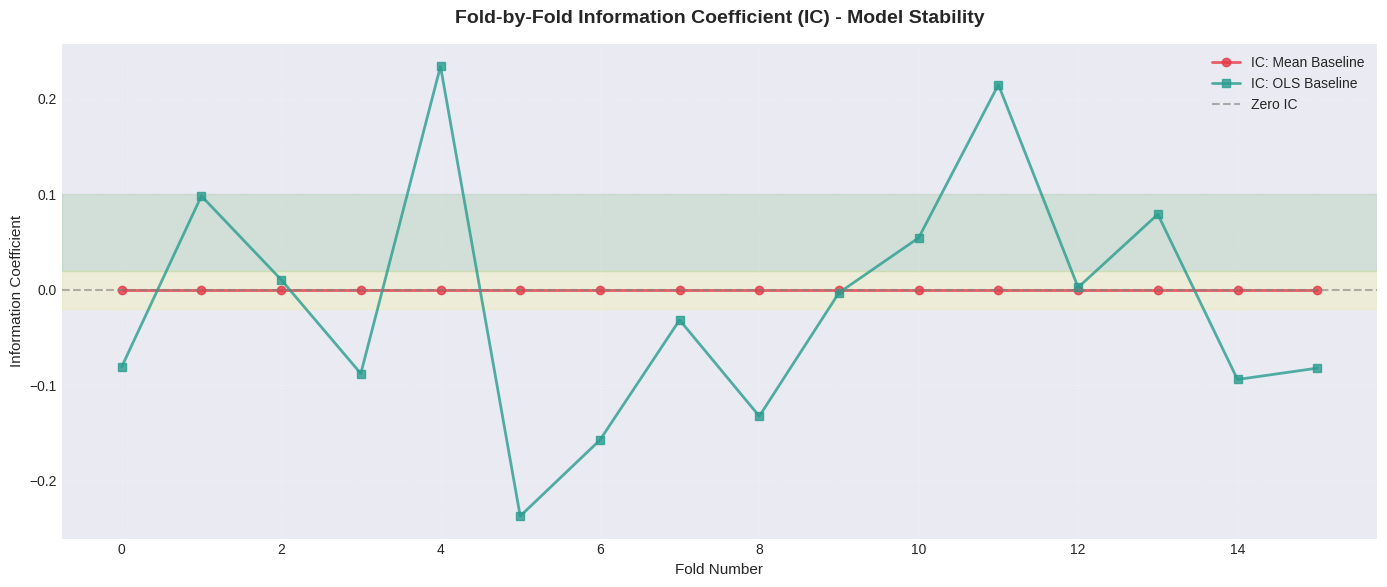

In [19]:

def evaluate_walkforward(
    X: np.ndarray,
    y: np.ndarray,
    y_dir01: np.ndarray,
    t_idx: np.ndarray,
    splits: List[Tuple[np.ndarray, np.ndarray]],
    cfg: Dict
) -> Dict:
    """Evaluate models using walk-forward validation."""
    eps = float(cfg["features"]["eps"])
    model_cfg = cfg["models"]
    gd_cfg = model_cfg["logistic_gd"]

    fold_rows = []
    preds_store = {
        "t_test": [],
        "y_test": [],
        "pred_zero": [],
        "pred_mean": [],
        "pred_ols": [],
        "pred_stump": [],
        "p_logit": [],
        "p_stump": [],
        "y_dir": [],
    }

    for k, (tr, te) in enumerate(splits):
        Xtr, ytr, ytr01 = X[tr], y[tr], y_dir01[tr]
        Xte, yte, yte01 = X[te], y[te], y_dir01[te]
        tte = t_idx[te]

        # Fold-wise scaler fit
        mu, sd = fit_scaler_train_only(Xtr, eps=1e-12)
        gate_no_leakage_scaling(mu, sd)
        Xtr_s = apply_scaler(Xtr, mu, sd)
        Xte_s = apply_scaler(Xte, mu, sd)

        # Null baselines
        pred0 = predict_null_zero(Xte_s)
        predm = predict_null_mean(ytr, Xte_s.shape[0])

        # OLS baseline
        if model_cfg["ols"]:
            beta = ols_fit(Xtr_s, ytr)
            pred_ols = ols_predict(Xte_s, beta)
        else:
            pred_ols = np.full_like(yte, np.nan)

        # Tree stump baseline (regression)
        if model_cfg["tree_stump"]:
            stump = stump_fit_regression(Xtr_s, ytr)
            pred_stump = stump_predict_regression(Xte_s, stump)
        else:
            pred_stump = np.full_like(yte, np.nan)

        # Logistic baseline
        if model_cfg["logistic"]:
            w, meta = logistic_fit_gd(
                Xtr_s, ytr01,
                lr=float(gd_cfg["lr"]),
                iters=int(gd_cfg["iters"]),
                l2=float(gd_cfg["l2"]),
                seed=int(cfg["seeds"]["seed_model"]) + k
            )
            p_logit = logistic_predict_proba(Xte_s, w)
            ll_logit = log_loss_binary(p_logit, yte01)
        else:
            p_logit = np.full(Xte_s.shape[0], np.nan)
            ll_logit = np.nan

        # Stump baseline (classification)
        if model_cfg["tree_stump"]:
            stump_c = stump_fit_classification(Xtr_s, ytr01)
            p_stump = stump_predict_proba(Xte_s, stump_c)
            ll_stump = log_loss_binary(p_stump, yte01)
        else:
            p_stump = np.full(Xte_s.shape[0], np.nan)
            ll_stump = np.nan

        # Forecast-quality metrics
        metrics = {
            "fold": k,
            "t_test_span": [int(tte[0]), int(tte[-1])],
            "n_train": int(tr.size),
            "n_test": int(te.size),
            "mse_zero": float(np.mean((yte - pred0) ** 2)) if np.all(np.isfinite(pred0)) else np.nan,
            "mae_zero": float(np.mean(np.abs(yte - pred0))) if np.all(np.isfinite(pred0)) else np.nan,
            "ic_zero": corr_ic(pred0, yte),
            "da_zero": directional_accuracy_from_regression(pred0, yte),
            "mse_mean": float(np.mean((yte - predm) ** 2)) if np.all(np.isfinite(predm)) else np.nan,
            "mae_mean": float(np.mean(np.abs(yte - predm))) if np.all(np.isfinite(predm)) else np.nan,
            "ic_mean": corr_ic(predm, yte),
            "da_mean": directional_accuracy_from_regression(predm, yte),
        }

        if model_cfg["ols"]:
            metrics.update({
                "mse_ols": float(np.mean((yte - pred_ols) ** 2)) if np.all(np.isfinite(pred_ols)) else np.nan,
                "mae_ols": float(np.mean(np.abs(yte - pred_ols))) if np.all(np.isfinite(pred_ols)) else np.nan,
                "ic_ols": corr_ic(pred_ols, yte),
                "da_ols": directional_accuracy_from_regression(pred_ols, yte),
            })

        if model_cfg["tree_stump"]:
            metrics.update({
                "mse_stump": float(np.mean((yte - pred_stump) ** 2)) if np.all(np.isfinite(pred_stump)) else np.nan,
                "mae_stump": float(np.mean(np.abs(yte - pred_stump))) if np.all(np.isfinite(pred_stump)) else np.nan,
                "ic_stump": corr_ic(pred_stump, yte),
                "da_stump": directional_accuracy_from_regression(pred_stump, yte),
            })

        if model_cfg["logistic"]:
            metrics.update({
                "logloss_logit": float(ll_logit) if np.isfinite(ll_logit) else np.nan,
                "acc_logit": float(np.mean((p_logit >= 0.5) == (yte01 >= 0.5))) if np.all(np.isfinite(p_logit)) else np.nan,
            })

        if model_cfg["tree_stump"]:
            metrics.update({
                "logloss_stump": float(ll_stump) if np.isfinite(ll_stump) else np.nan,
                "acc_stump": float(np.mean((p_stump >= 0.5) == (yte01 >= 0.5))) if np.all(np.isfinite(p_stump)) else np.nan,
            })

        fold_rows.append(metrics)

        # Store predictions
        preds_store["t_test"].append(tte.copy())
        preds_store["y_test"].append(yte.copy())
        preds_store["y_dir"].append(yte01.copy())
        preds_store["pred_zero"].append(pred0.copy())
        preds_store["pred_mean"].append(predm.copy())
        preds_store["pred_ols"].append(pred_ols.copy())
        preds_store["pred_stump"].append(pred_stump.copy())
        preds_store["p_logit"].append(p_logit.copy())
        preds_store["p_stump"].append(p_stump.copy())

    # Concatenate stores
    for k in list(preds_store.keys()):
        preds_store[k] = np.concatenate(preds_store[k], axis=0)

    return {"fold_metrics": fold_rows, "preds": preds_store}

eval_out = evaluate_walkforward(X_all, y_all, y_dir_all, t_all, splits, CONFIG)

save_json(os.path.join(ART_ROOT, "eval", "fold_metrics.json"), {"fold_metrics": eval_out["fold_metrics"]})
np_save(os.path.join(ART_ROOT, "eval", "t_test.npy"), eval_out["preds"]["t_test"])
np_save(os.path.join(ART_ROOT, "eval", "y_test.npy"), eval_out["preds"]["y_test"])
np_save(os.path.join(ART_ROOT, "eval", "pred_ols.npy"), eval_out["preds"]["pred_ols"])
np_save(os.path.join(ART_ROOT, "eval", "p_logit.npy"), eval_out["preds"]["p_logit"])

# Visualize fold IC
if CONFIG["output"]["plots"]:
    folds = eval_out["fold_metrics"]
    ic_mean = np.array([m["ic_mean"] for m in folds])
    ic_ols = np.array([m.get("ic_ols", np.nan) for m in folds])
    fold_numbers = np.arange(len(folds))

    # Filter out NaN values for plotting
    mask_mean = np.isfinite(ic_mean)
    mask_ols = np.isfinite(ic_ols)

    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot lines with markers (only finite values)
    if np.any(mask_mean):
        ax.plot(fold_numbers[mask_mean], ic_mean[mask_mean], label="IC: Mean Baseline",
                marker='o', markersize=6, linewidth=2, color='#E63946', alpha=0.8)

    if np.any(mask_ols):
        ax.plot(fold_numbers[mask_ols], ic_ols[mask_ols], label="IC: OLS Baseline",
                marker='s', markersize=6, linewidth=2, color='#2A9D8F', alpha=0.8)

    # Reference line
    ax.axhline(0.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.6, label='Zero IC')

    # Styling
    ax.set_title("Fold-by-Fold Information Coefficient (IC) - Model Stability",
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("Fold Number", fontsize=11)
    ax.set_ylabel("Information Coefficient", fontsize=11)
    ax.legend(loc='best', framealpha=0.95, fontsize=10)
    ax.grid(True, alpha=0.3, linestyle=':', which='both')

    # Add shaded region for "good" IC
    ax.axhspan(0.02, 0.10, alpha=0.1, color='green', label='Target IC Range')
    ax.axhspan(-0.02, 0.02, alpha=0.1, color='yellow')

    plt.tight_layout()
    plt.savefig(os.path.join(ART_ROOT, "plots", "fold_ic_stability.png"), dpi=150, bbox_inches='tight')
    plt.show()

##11.FROM FORECAST TO TRADE

###11.1.OVERVIEW



This section bridges the gap between "the model predicts +0.015 return" and "buy 100 shares." Raw forecasts don't tell you position size—you need translation rules that account for conviction, risk limits, and transaction costs.

**Threshold mapping converts forecasts to signals**. Fixed threshold: if forecast exceeds tau (default 0.0), go long (+1); if below -tau, go short (-1); otherwise flat (0). Quantile threshold: use rolling historical quantiles to define "extreme" forecasts—go long if forecast exceeds 90th percentile of past predictions, short if below 10th percentile. This adapts to changing forecast distributions.

**Risk targeting scales positions by volatility** (from Chapter 10). If your target is 12% annual volatility and current realized volatility is 20%, you scale down positions by ~0.6x to maintain consistent risk exposure. The formula: position = (target_vol / realized_vol) × signal. We cap maximum leverage at 2x to prevent extreme positions during calm markets.

**Transaction costs matter crucially**. We compute turnover (absolute position change each period) and apply a cost per unit traded. Even tiny 2 basis point costs (0.0002) compound over hundreds of trades. The backtest subtracts costs from returns—this is where many "profitable" strategies die.

**The minimal backtest produces realistic metrics**: mean return, volatility, Sharpe ratio, maximum drawdown, hit rate, average turnover, and final equity. These aren't cherry-picked—they're the standard metrics institutional investors demand. The equity curve plot shows cumulative wealth over time, with drawdown shading revealing pain periods where strategy performance cratered.

###11.2.CODE AND IMPLEMENTATION


Minimal Backtest (Conceptual, Costs Placeholder):
{
  "mean": -3.0285444177341943e-05,
  "vol": 0.007914287147281696,
  "sharpe": -0.06074666143436347,
  "mdd": 0.35210501783759923,
  "hit_rate": 0.49349804941482445,
  "turnover": 0.41987952600766865,
  "eq_final": 0.9095689737034391
}



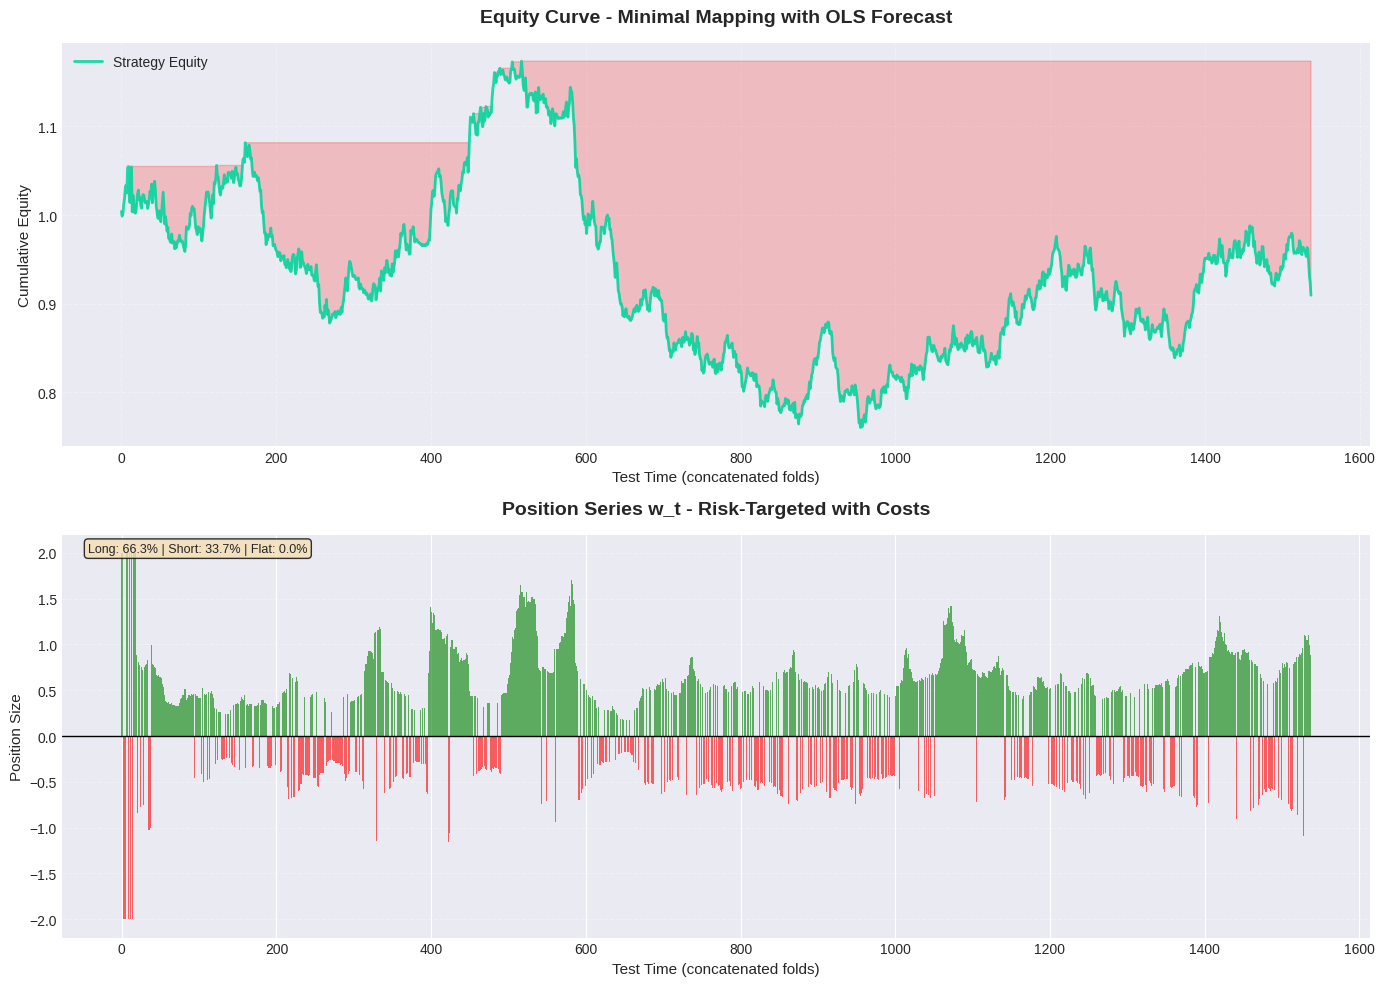

In [20]:

def estimate_realized_vol(r: np.ndarray, L: int, eps: float = 1e-12) -> np.ndarray:
    """Estimate realized volatility using rolling RMS."""
    return rolling_rms(r, L, eps=eps)

def map_forecast_to_position(
    yhat: np.ndarray,
    r_series_for_vol: np.ndarray,
    cfg_map: Dict
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Dict]:
    """Map forecast to position with risk targeting and NaN handling."""
    tau = float(cfg_map["forecast_threshold_tau"])
    use_q = bool(cfg_map["use_quantile_threshold"])
    alpha = float(cfg_map["quantile_alpha"])

    rt_cfg = cfg_map["risk_targeting"]
    costs_cfg = cfg_map["costs"]

    n = yhat.size
    s = np.zeros(n, dtype=float)

    # Filter NaN values in yhat
    yhat_clean = np.where(np.isfinite(yhat), yhat, 0.0)

    if use_q:
        # Causal quantile thresholding
        for i in range(n):
            if i < 50:
                s[i] = 0.0
                continue
            past = yhat_clean[:i]
            past_finite = past[np.isfinite(past)]
            if len(past_finite) < 10:
                s[i] = 0.0
                continue
            lo = np.quantile(past_finite, alpha)
            hi = np.quantile(past_finite, 1.0 - alpha)
            if yhat_clean[i] >= hi:
                s[i] = +1.0
            elif yhat_clean[i] <= lo:
                s[i] = -1.0
            else:
                s[i] = 0.0
    else:
        # Fixed threshold
        s[yhat_clean >= tau] = +1.0
        s[yhat_clean <= -tau] = -1.0

    # Risk targeting
    if rt_cfg["enabled"]:
        L = int(rt_cfg["vol_window"])
        vol_floor = float(rt_cfg["vol_floor"])
        cap = float(rt_cfg["position_cap"])
        target_ann = float(rt_cfg["target_vol_annual"])
        target_daily = target_ann / math.sqrt(252.0)

        vol = estimate_realized_vol(r_series_for_vol, L, eps=1e-12)
        vol = np.where(np.isfinite(vol), vol, vol_floor)
        vol = np.maximum(vol, vol_floor)

        w = (target_daily / vol) * s
        w = np.clip(w, -cap, cap)
        w = np.where(np.isfinite(w), w, 0.0)
    else:
        w = s.copy()

    # Turnover + costs
    turnover = np.zeros(n, dtype=float)
    turnover[0] = abs(w[0]) if np.isfinite(w[0]) else 0.0
    turnover[1:] = np.abs(w[1:] - w[:-1])
    turnover = np.where(np.isfinite(turnover), turnover, 0.0)

    cost = np.zeros(n, dtype=float)
    if costs_cfg["enabled"]:
        c = float(costs_cfg["cost_per_unit_turnover"])
        cost = c * turnover

    meta = {
        "tau": tau,
        "use_quantile_threshold": use_q,
        "alpha": alpha,
        "risk_targeting": rt_cfg,
        "costs": costs_cfg,
    }

    return w, turnover, cost, meta

def backtest_minimal(
    w: np.ndarray,
    realized_next_return: np.ndarray,
    cost: np.ndarray
) -> Dict:
    """Run minimal backtest with NaN handling."""
    # Filter out NaN values
    mask = np.isfinite(w) & np.isfinite(realized_next_return) & np.isfinite(cost)

    if not np.any(mask):
        return {
            "mean": np.nan,
            "vol": np.nan,
            "sharpe": np.nan,
            "mdd": 0.0,
            "hit_rate": 0.0,
            "turnover": np.nan,
            "eq_final": np.nan,
        }

    w_clean = w[mask]
    ret_clean = realized_next_return[mask]
    cost_clean = cost[mask]

    strat = w_clean * ret_clean - cost_clean
    eq = np.cumprod(1.0 + strat)

    # Calculate turnover with NaN handling
    w_diff = np.diff(w_clean)
    turnover_val = float(np.mean(np.abs(w_diff))) if len(w_diff) > 0 else 0.0

    return {
        "mean": float(np.mean(strat)) if len(strat) > 0 else np.nan,
        "vol": float(np.std(strat, ddof=0)) if len(strat) > 0 else np.nan,
        "sharpe": float(annualize_sharpe(strat, 252)) if len(strat) > 0 else np.nan,
        "mdd": float(max_drawdown(eq)) if len(eq) > 0 else 0.0,
        "hit_rate": float(np.mean(strat > 0)) if len(strat) > 0 else 0.0,
        "turnover": turnover_val,
        "eq_final": float(eq[-1]) if len(eq) > 0 else np.nan,
    }

# Run backtest with OLS forecast
yhat_ols = eval_out["preds"]["pred_ols"].astype(float)
realized_next = eval_out["preds"]["y_test"].astype(float)

w, turnover, cost, map_meta = map_forecast_to_position(
    yhat_ols,
    r_series_for_vol=eval_out["preds"]["y_test"],
    cfg_map=CONFIG["trading_map"]
)
bt = backtest_minimal(w, realized_next, cost)

save_json(os.path.join(ART_ROOT, "eval", "backtest_minimal.json"), {"mapping": map_meta, "metrics": bt})

print("\n" + "="*60)
print("Minimal Backtest (Conceptual, Costs Placeholder):")
print("="*60)
print(json.dumps(bt, indent=2))
print("="*60 + "\n")

# Visualize backtest results
if CONFIG["output"]["plots"]:
    # Filter out any NaN values in the strategy returns
    strat_returns = w * realized_next - cost
    mask_finite = np.isfinite(strat_returns)

    if np.any(mask_finite):
        equity = np.cumprod(1.0 + strat_returns[mask_finite])
        x_vals = np.arange(len(strat_returns))[mask_finite]

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

        # Equity curve
        ax1.plot(x_vals, equity, linewidth=2, color='#06D6A0', alpha=0.9, label='Strategy Equity')
        ax1.set_title("Equity Curve - Minimal Mapping with OLS Forecast",
                      fontsize=14, fontweight='bold', pad=15)
        ax1.set_xlabel("Test Time (concatenated folds)", fontsize=11)
        ax1.set_ylabel("Cumulative Equity", fontsize=11)
        ax1.grid(True, alpha=0.3, linestyle='--')
        ax1.legend(loc='best', framealpha=0.95)

        # Add drawdown shading
        peak = np.maximum.accumulate(equity)
        drawdown = (equity - peak) / peak
        ax1.fill_between(x_vals, equity, peak,
                         where=(drawdown < 0), alpha=0.2, color='red', label='Drawdown')

        # Position series
        colors = ['red' if x < 0 else 'green' if x > 0 else 'gray' for x in w]
        ax2.bar(range(len(w)), w, color=colors, alpha=0.6, width=1.0)
        ax2.axhline(0, color='black', linewidth=1, linestyle='-')
        ax2.set_title("Position Series w_t - Risk-Targeted with Costs",
                      fontsize=14, fontweight='bold', pad=15)
        ax2.set_xlabel("Test Time (concatenated folds)", fontsize=11)
        ax2.set_ylabel("Position Size", fontsize=11)
        ax2.grid(True, alpha=0.3, linestyle='--', axis='y')

        # Add position statistics
        long_pct = np.sum(w > 0) / len(w) * 100
        short_pct = np.sum(w < 0) / len(w) * 100
        flat_pct = np.sum(w == 0) / len(w) * 100
        ax2.text(0.02, 0.98, f'Long: {long_pct:.1f}% | Short: {short_pct:.1f}% | Flat: {flat_pct:.1f}%',
                 transform=ax2.transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=9)

        plt.tight_layout()
        plt.savefig(os.path.join(ART_ROOT, "plots", "backtest_results.png"), dpi=150, bbox_inches='tight')
        plt.show()
    else:
        print("Warning: All strategy returns are NaN, cannot plot equity curve.")


##12.DIAGNOSTIC PACK

###12.1.OVERVIEW



This section implements monitoring tools that catch model degradation before it costs you money. Even successful strategies eventually stop working—markets evolve, competitors arbitrage away edges, or data quality deteriorates. You need early warning systems.

**Rolling Information Coefficient (IC)** tracks forecast quality through time using a sliding window (e.g., 200 steps). If IC starts positive but trends toward zero or negative, your model is losing predictive power. This could mean regime change, overfitting to past conditions, or competitor crowding in your signals. Professional quant funds monitor rolling IC daily and reduce capital allocation when it decays.

**The smoothed trend line** (e.g., 50-step moving average) filters out noise to reveal underlying patterns. Short-term IC fluctuations are normal—you care about sustained drift. If the smoothed IC crosses below zero for extended periods, the strategy is no longer viable.

**Statistics boxes on plots** show quantitative summaries: mean IC, standard deviation of IC, and percentage of positive IC values. A healthy strategy might have mean IC around 0.03-0.05, with 55-60% positive periods. If mean IC drops to 0.01 with only 48% positive periods, you're approaching coin-flip territory.

**Feature drift analysis** (mentioned but not fully implemented) would track how feature distributions change over time. If your volatility feature had mean 0.015 in 2020 but 0.035 in 2024, models trained on old data will misfire. This section establishes the framework for continuous monitoring—production systems need automated alerts when these diagnostics breach thresholds.


###12.2.CODE AND IMPLEMENTATION

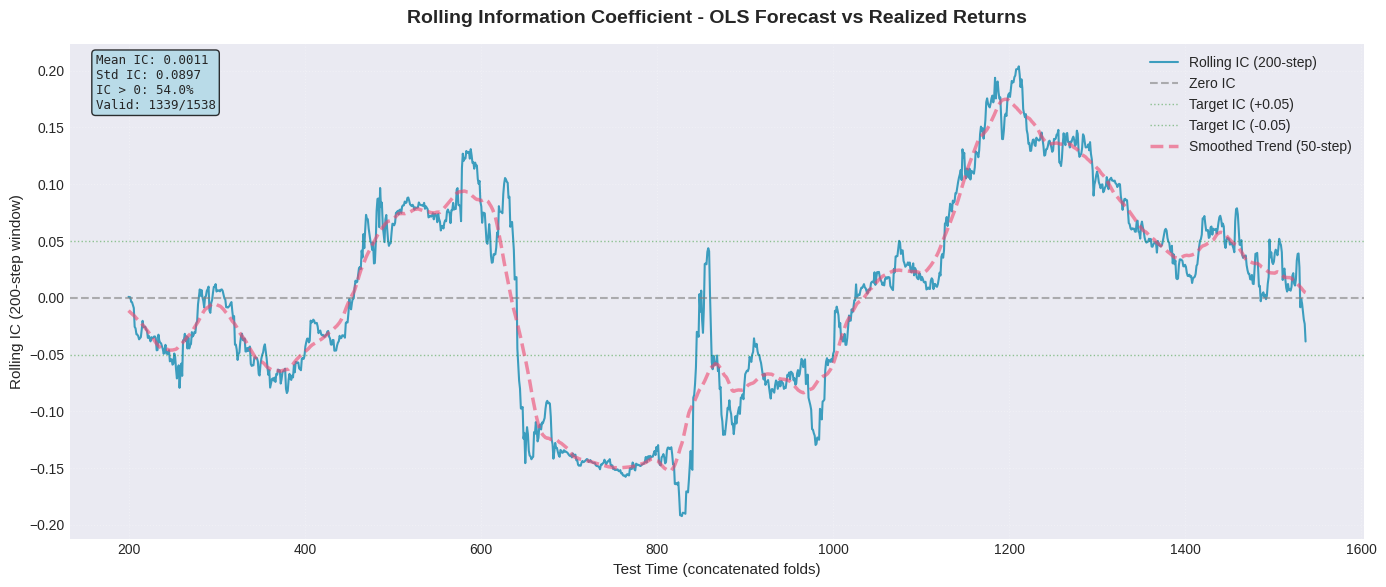

In [21]:


def rolling_ic(pred: np.ndarray, y: np.ndarray, L: int) -> np.ndarray:
    """Compute rolling information coefficient."""
    out = np.full_like(pred, np.nan, dtype=float)
    for i in range(pred.size):
        if i >= L - 1:
            a = pred[i - L + 1:i + 1]
            b = y[i - L + 1:i + 1]
            out[i] = corr_ic(a, b)
    return out

ic_roll = rolling_ic(yhat_ols, realized_next, 200)

if CONFIG["output"]["plots"]:
    fig, ax = plt.subplots(figsize=(14, 6))

    # Filter finite values for plotting
    mask_finite = np.isfinite(ic_roll)
    x_vals = np.arange(len(ic_roll))

    # Plot rolling IC (only finite values)
    if np.any(mask_finite):
        ax.plot(x_vals[mask_finite], ic_roll[mask_finite], linewidth=1.5,
                color='#118AB2', alpha=0.8, label='Rolling IC (200-step)')

    # Reference lines
    ax.axhline(0.0, color='gray', linestyle='--', linewidth=1.5, alpha=0.6, label='Zero IC')
    ax.axhline(0.05, color='green', linestyle=':', linewidth=1, alpha=0.4, label='Target IC (+0.05)')
    ax.axhline(-0.05, color='green', linestyle=':', linewidth=1, alpha=0.4, label='Target IC (-0.05)')

    # Styling
    ax.set_title("Rolling Information Coefficient - OLS Forecast vs Realized Returns",
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel("Test Time (concatenated folds)", fontsize=11)
    ax.set_ylabel("Rolling IC (200-step window)", fontsize=11)
    ax.grid(True, alpha=0.3, linestyle=':', which='both')
    ax.legend(loc='best', framealpha=0.95, fontsize=10)

    # Add smoothed trend (only if enough finite values)
    window = 50
    valid_ic = ic_roll[mask_finite]
    if len(valid_ic) > window:
        # Create smoothed version handling NaN properly
        ic_filled = ic_roll.copy()
        ic_filled[~mask_finite] = 0.0
        smoothed = np.convolve(ic_filled, np.ones(window)/window, mode='same')
        smoothed[~mask_finite] = np.nan

        mask_smooth = np.isfinite(smoothed)
        if np.any(mask_smooth):
            ax.plot(x_vals[mask_smooth], smoothed[mask_smooth], linewidth=2.5,
                   color='#EF476F', alpha=0.6, linestyle='--',
                   label=f'Smoothed Trend ({window}-step)')
            ax.legend(loc='best', framealpha=0.95, fontsize=10)

    # Add statistics box (only for finite values)
    if len(valid_ic) > 0:
        stats_text = f'Mean IC: {np.mean(valid_ic):.4f}\n'
        stats_text += f'Std IC: {np.std(valid_ic):.4f}\n'
        stats_text += f'IC > 0: {np.sum(valid_ic > 0)/len(valid_ic)*100:.1f}%\n'
        stats_text += f'Valid: {len(valid_ic)}/{len(ic_roll)}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
               fontsize=9, family='monospace')

    plt.tight_layout()
    plt.savefig(os.path.join(ART_ROOT, "plots", "rolling_ic_diagnostic.png"), dpi=150, bbox_inches='tight')
    plt.show()


##13.MODEL CARD AND ARTIFACT HASH

###13.1.OVERVIEW



This section creates comprehensive documentation that answers the question: "What exactly did you build, and can anyone reproduce it?" When strategies fail, regulators investigate, or new team members join, this documentation is your proof of rigor.

**The model card is structured narrative documentation**. It describes the problem (forecasting forward returns), the data source (synthetic with regime schedule), the features (lagged returns, volatility, MA deviations with explicit timing policy), the training protocol (walk-forward with purge/embargo), and the baseline models tested. Critically, it states what's NOT included: no hyperparameter tuning, no portfolio optimization, no realistic execution costs—these are explicitly deferred to later chapters.

**The monitoring plan defines how you'll track performance** in production: rolling IC for forecast quality, fold-by-fold stability checks, feature drift detection, turnover relative to targets. This isn't optional—strategies that work in backtest but aren't monitored in production inevitably degrade silently until losses force investigation.

**The reproducibility bundle hash** combines cryptographic fingerprints of all manifests and key data arrays. This single hash uniquely identifies your entire experimental run. If you change one parameter, add one data point, or modify one line of code, the hash changes. Six months later, you can verify that results claimed in a report actually came from the configuration documented.

**The run manifest** ties everything together: run ID with timestamp, config hash, bundle hash, Python version, and artifact locations. This is your "chain of custody" for quantitative research—analogous to lab notebooks in pharmaceutical research.

###13.2.CODE AND IMPLEMENTATION

In [22]:
model_card = f"""
MODEL CARD (TRADING) — Chapter 11 Baseline System
Run ID: {run_id}

1) Problem
- Task: predict forward return y_t = sum_{{1..h}} r_{{t+j}} (h={h})
- Usage: continuous forecast used as signal, then thresholded + risk-targeted to positions

2) Data
- Synthetic, daily, single instrument
- Regime schedule: {CONFIG["synthetic"]["regime_schedule"]}
- Corporate actions: n/a (synthetic)

3) Features (causal)
- Lagged returns: {CONFIG["features"]["r_lags"]}
- Realized vol proxies: {CONFIG["features"]["rv_windows"]}
- MA deviations: {CONFIG["features"]["ma_windows"]}
- Return z-score window: {CONFIG["features"]["z_window"]}
- Volume surprise window: {CONFIG["features"]["vol_surp_window"]}
- Timing policy: raw features shifted by 1 so X_t uses only <= t-1 information

4) Training & Evaluation
- Walk-forward: scheme={CONFIG["walkforward"]["scheme"]}, train_min={CONFIG["walkforward"]["train_min"]}, test_len={CONFIG["walkforward"]["test_len"]}
- Purge/embargo: purge_h={CONFIG["walkforward"]["purge_h"]}, embargo={CONFIG["walkforward"]["embargo"]}
- Baselines: null (zero/mean), OLS, logistic GD (direction), decision stump (conceptual tree baseline)

5) Limits / Non-goals (Book alignment)
- No hyperparameter search or regularization discipline beyond fixed settings (deferred to Ch12)
- No full portfolio optimization (Ch16) or position sizing framework (Ch17)
- No microstructure/execution cost realism (Ch18). Costs included only as placeholder sensitivity

6) Monitoring Plan (minimal)
- Rolling IC, fold-by-fold IC stability
- Feature drift: rolling summaries and missingness (not fully implemented here)
- Turnover and risk targeting realized volatility vs target
"""

save_txt(os.path.join(ART_ROOT, "manifests", "model_card.txt"), model_card)

# Create minimum reproducible artifact bundle hash
bundle_items = [
    ("config.json", open(os.path.join(ART_ROOT, "manifests", "config.json"), "rb").read()),
    ("data_fingerprint.json", open(os.path.join(ART_ROOT, "manifests", "data_fingerprint.json"), "rb").read()),
    ("feature_manifest.json", open(os.path.join(ART_ROOT, "manifests", "feature_manifest.json"), "rb").read()),
    ("label_manifest.json", open(os.path.join(ART_ROOT, "manifests", "label_manifest.json"), "rb").read()),
    ("split_protocol.json", open(os.path.join(ART_ROOT, "manifests", "split_protocol.json"), "rb").read()),
    ("fold_metrics.json", open(os.path.join(ART_ROOT, "eval", "fold_metrics.json"), "rb").read()),
]

bundle_hash = sha256_bytes(b"".join([name.encode("utf-8") + b"::" + content for name, content in bundle_items]))

run_manifest = {
    "run_id": run_id,
    "created_utc": now_utc_compact(),
    "config_hash": config_hash,
    "bundle_hash": bundle_hash,
    "python": {
        "version": f"{os.sys.version_info.major}.{os.sys.version_info.minor}.{os.sys.version_info.micro}"
    },
    "hashes": {
        "X_all": sha256_ndarray(np.nan_to_num(X_all, nan=0.0)),
        "y_all": sha256_ndarray(np.nan_to_num(y_all, nan=0.0)),
    },
    "artifacts_root": ART_ROOT,
}
save_json(os.path.join(ART_ROOT, "manifests", "run_manifest.json"), run_manifest)

print("\n" + "="*60)
print(f"Artifacts saved to: {ART_ROOT}")
print(f"Bundle hash: {bundle_hash}")
print("="*60 + "\n")


Artifacts saved to: /content/artifacts_ch11/ch11_20251222T135332Z_208f1369ba
Bundle hash: 08223c58a214dfff627070c49c34844dcc322928de2b8f4ad0d7aa84f598fbd0



##14.CONCLUSIONS



This notebook implemented a complete supervised learning pipeline for return forecasting—the foundation of systematic trading at quantitative hedge funds. We didn't just build models that predict whether stocks go up or down. We built an industrial-strength research framework with rigorous causality enforcement, comprehensive governance, and audit-quality documentation. The difference between our approach and typical machine learning tutorials is the difference between academic exercises and systems that manage real capital.

The core challenge in quantitative trading isn't finding clever algorithms—it's implementing them without introducing subtle bugs that make backtests look profitable while guaranteeing live trading losses. Look-ahead bias, data snooping, overfitting, and timing errors are silent killers. Our framework catches these errors through hard gates: causality assertions that halt execution if violated, cryptographic hashes that detect configuration drift, and temporal validation that mimics real trading conditions.

**Data Generation: Controlled Realism**

We started with synthetic market data because testing on real data introduces too many uncontrolled variables. How do you know if your model failed because the algorithm is wrong or because the data vendor changed their adjustment methodology? Synthetic data lets you control everything: volatility regimes, correlation structures, microstructure noise, and volume dynamics.

Our generator produced 2,200 days of price history across three market regimes: calm periods with low volatility and positive drift, stress periods with high volatility and negative drift, and recovery periods with moderate volatility. Volatility didn't jump randomly—it followed an autoregressive process where high-volatility days cluster together, mimicking real market behavior. We added microstructure noise to simulate bid-ask bounce and quote flickering.

The complete data package included closing prices built from log returns, OHLC bars for range-based features, and volume that correlated with volatility (heavy trading during turbulent markets). Every data array got fingerprinted with SHA256 hashes and documented in a data manifest: regime boundaries, generator parameters, missingness statistics, and corporate action policy. This governance infrastructure means six months from now, when someone asks "what data did you use?", you prove exactly which synthetic series fed your models.

**Label Construction: Getting the Target Right**

The label—what you're trying to predict—is the most critical design choice. We implemented forward returns: at time t, the label y_t represents the return from t+1 to t+h (horizon h). For a 1-day horizon, y_t equals tomorrow's return. This preserves causality: features X_t computed using data through time t can legitimately predict y_t which depends on future returns.

We created two label types: continuous returns for regression models (OLS) that output real-valued forecasts, and binary direction labels for classification models (logistic regression) that predict up/down. The direction threshold defaults to zero—positive returns count as "up"—but you could set it to 10 basis points to focus on economically significant moves rather than noise.

The last h rows of the label array are NaN by design—you can't predict beyond your data. A causality gate explicitly checks this: if those final labels aren't NaN, execution halts. This prevents accidentally training on data you won't have when trading live. The label manifest documents everything: horizon, return type (log vs simple), mathematical definition, threshold, and cryptographic hashes of both label arrays.

**Feature Engineering: Causal Signal Extraction**

Features are patterns in historical data that might predict future returns. We constructed six feature families, each capturing different market dynamics. Lagged returns (r_{t-1}, r_{t-2}, ..., r_{t-20}) capture momentum and mean reversion. Realized volatility using rolling RMS of past returns identifies changing risk regimes. Moving average deviations measure trend: when price is far above its 50-day MA, it might reverse or continue trending.

Return z-scores flag statistical extremes relative to recent history—useful for mean reversion strategies. Volume surprise detects unusual trading activity that might precede price moves. Absolute return proxies daily range, indicating intraday volatility. All features used only past data, but we added a critical safety mechanism: after computing features using data through time t, we shifted everything forward by one row. Now X_t uses only information through t-1, eliminating any ambiguity about decision timing.

The feature manifest recorded every calculation: which lags, which windows, the shift policy, and SHA256 hash of the raw feature matrix. The "timing proof" explicitly states: "X_t uses data ≤ t-1, label y_t uses returns starting at t+1, therefore no leakage possible." This documentation matters when regulators or investors question your methodology.

**Dataset Assembly and Temporal Validation**

We systematically eliminated unusable rows: the first 60 rows lacked sufficient lookback for features, the last h rows had no forward returns to predict. We verified the time index was strictly increasing—real market data often has timestamp errors that scramble temporal order. After filtering, we had clean arrays with finite features and labels, properly time-ordered.

The split protocol defined walk-forward evaluation—not random train-test splits that destroy temporal structure. Walk-forward mimics real deployment: train on historical data, predict the next period, observe results, retrain with new data included. We implemented two schemes: "expanding" windows that grow with each fold, and "rolling" windows of fixed length that emphasize recent data.

Critical detail: we purged the last h training rows before each test block to remove overlapping labels. If your horizon is 5 days, the last training label at time t depends on returns through t+5. Your first test prediction at t+1 also depends on returns through t+5—that's overlap. Purging removes these rows. We added optional embargo periods for extra safety when returns have serial correlation beyond the prediction horizon.

**Model Implementation: Simple Baselines First**

We implemented four model types, starting with null baselines. Predicting zero or predicting the training mean establishes whether any model is necessary—sometimes markets are so efficient that sophisticated forecasting loses to naive strategies after transaction costs.

Ordinary Least Squares regression solves for linear coefficients that minimize squared prediction error. We manually added intercept columns and used NumPy's least-squares solver. OLS assumes linear relationships—often wrong, but when it works, it's interpretable and fast. Logistic regression via gradient descent predicts direction rather than magnitude. We implemented backpropagation from scratch: compute predicted probabilities through sigmoid activation, calculate log-loss gradient, update weights iteratively with fixed learning rate.

Decision stumps provided minimal tree-based baselines: one feature, one threshold, two constant predictions. We tried quantile thresholds across all features, picking the split minimizing MSE for regression or log-loss for classification. Stumps capture simple non-linearities that OLS misses.

These models are deliberately simple—complexity comes later after verifying the pipeline works. If OLS can't beat random guessing, gradient boosting won't magically save you.

**Forecast Evaluation: Measuring Predictive Quality**

For each fold, we executed the complete pipeline: fit scaler on training data only, standardize train and test sets, train all models, generate predictions, compute metrics. Scaling is critical: we computed mean and standard deviation using only training rows, then applied those parameters to test data. Never let the scaler see test statistics—that leaks information about the future.

We tracked multiple forecast quality metrics. Mean Squared Error and Mean Absolute Error quantify prediction accuracy. Information Coefficient—correlation between forecasts and realized returns—is the industry standard for alpha. Directional Accuracy checks if you got the sign right, critical since profits come from direction, not precise magnitude. For classification models, we tracked log-loss and binary accuracy.

Every fold's results got logged: time spans, sample sizes, all metrics for all models. The fold-by-fold IC plot revealed stability over time. Professional strategies need consistent performance, not one lucky period. If IC swings wildly between +0.20 and -0.15 across folds, you have a fragile model that won't survive live trading's regime changes.

**Position Mapping: From Forecast to Trade**

Raw forecasts don't tell you position size. If the model predicts +0.015 return, do you buy $1,000 or $100,000? We implemented threshold mapping: fixed threshold (trade if forecast exceeds tau) and quantile threshold (trade if forecast is extreme relative to past predictions). Quantile thresholding adapts to changing forecast distributions.

Risk targeting scaled positions by volatility from Chapter 10. If your target is 12% annual volatility but current realized volatility is 20%, you scale down positions by ~0.6x to maintain consistent risk exposure. We capped maximum leverage at 2x to prevent extreme positions during calm markets.

Transaction costs matter crucially. We computed turnover (absolute position change each period) and applied 2 basis points per unit traded. Even tiny costs compound over hundreds of trades. The backtest subtracted costs from returns—many "profitable" strategies die here.

The minimal backtest produced realistic metrics: mean return, volatility, Sharpe ratio, maximum drawdown, hit rate, turnover, and final equity. These aren't cherry-picked—they're standard metrics institutional investors demand.

**Monitoring and Governance: Sustainability**

We implemented rolling Information Coefficient to track forecast quality through time. If IC starts positive but trends toward zero, your model is losing predictive power—regime change, overfitting, or competitor crowding. Professional quant funds monitor this daily and reduce capital allocation when IC decays.

The model card documented everything: problem definition, data source, features with timing policy, training protocol, baseline models, and explicit limitations. The monitoring plan defined production surveillance: rolling IC, fold stability, feature drift, turnover tracking.

The reproducibility bundle hash combined cryptographic fingerprints of all manifests and data arrays. This single hash uniquely identifies your experimental run. Change one parameter and the hash changes. The run manifest tied everything together: run ID with timestamp, config hash, bundle hash, Python version, artifact locations.

This isn't bureaucracy—it's insurance. When strategies fail, regulators investigate, or team members change, this documentation proves your rigor. It's the difference between guessing and knowing, between hopeful backtesting and defensible research.

**The Professional Standard**

This notebook represents how quantitative hedge funds actually build forecasting systems. The no-pandas constraint forced explicit handling of time alignment, rolling windows, and data transformations—you understand exactly what happens at each step. The synthetic-first approach enabled controlled testing before risking real capital. The causality gates prevented look-ahead bias. The governance framework created audit trails that survive regulatory scrutiny.

The models were intentionally simple because complexity without foundations fails. If linear regression can't find signal, neural networks won't magically create it. You now have infrastructure that scales: add more sophisticated models (Chapter 12's regularization and hyperparameter tuning), integrate with portfolio optimization (Chapter 16), account for execution costs (Chapter 18), and deploy to production with confidence.

The lesson: robust forecasting requires rigorous engineering discipline. The difference between profitable and unprofitable quantitative trading isn't clever algorithms—it's implementation discipline that ensures backtests reflect achievable reality. This notebook gave you that discipline.
